# ML & Web scraping

### Data set used for ML part was created during Web Scrapping process.<br>
### For ML PART: code is as a MARKDOWN to keep data and results as they are shown in the report. Please load attached file created as a result of web scrapping.
### For Programming: please remove mardown and use web scrapping code.

In [1]:
# loading libraries
import requests
from bs4 import BeautifulSoup 
import pandas as pd
import re
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV

# getting a User-Agent from https://httpbin.org/get
headers = { "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36 Edg/105.0.1343.27", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}


baseurl = 'https://www.property.ie/property-for-sale/dublin/price_0-950000/'

In [ ]:
productlinks = []
for x in range(1,120):
    r = requests.get(f'https://www.property.ie/property-for-sale/dublin/price_0-950000/p_{x}/')
    soup = BeautifulSoup(r.content, 'html.parser')
    productlist = soup.find_all('div', class_='search_result')

    for item in productlist:
        link = item.find('a', href=True)
        if link:
            productlinks.append(link['href'])

print(productlinks)

House = []
for link in productlinks:
    r = requests.get(link, headers=headers)
    soup = BeautifulSoup(r.content, 'lxml')
    
# address
    address = soup.find('h1', style = 'clear: left').text.strip()
    
    
# pulling the data
    na = soup.find("div", id="searchmoreinfo_summary")
    name = na.get_text(strip=True)
    
    
# extract price
    price_match = re.search(r'€([\d,]+)',name)
    if price_match:
        price = price_match.group(1)
    else:
        price = None

# pulling the number of bedrooms and bathrooms
    bedrooms_match = re.search(r'(\d+) Bedrooms', name)
    if bedrooms_match:
        bedrooms = bedrooms_match.group(1)
    else:
        bedrooms = None

    bathrooms_match = re.search(r'(\d+) Bathrooms', name)
    if bathrooms_match:
        bathrooms = bathrooms_match.group(1)
    else:
        bathrooms = None

# extracting house type
    house_type_match = re.search(r'(\w+ House)', name)
    if house_type_match:
        house_type = str(house_type_match.group(1))
    else:
        house_type = None
        
    
    if house_type is not None:
        house_type.startswith('000')
        house_type = house_type.lstrip('0')
    else:
        house_type = None


# creating a dictionary with the extracted information
    info = {'Address':address,
        'Price': price,
        'Bedrooms': bedrooms,
        'Bathrooms': bathrooms,
        'House Type': house_type
}
    House.append(info)
    print(info)

# saving data as dataFrame
df_Dublin = pd.DataFrame(House)

In [ ]:
# saving file into and excel file
# df_Dublin.to_excel('C:\\ESTERA\\CA2\\data sets - IRL\\Dublin_Houses.xlsx', index=False)

In [56]:
# loading data set
df_Dublin = pd.read_excel('C:\\ESTERA\\CA2\\data sets - IRL\\Dublin_Houses.xlsx')

df_Dublin.head()

,Address,Price,Bedrooms,Bathrooms,House Type
0,"67 Park Drive Avenue, Castleknock, Castleknock...","550,000",3.0,2.0,Terraced House
1,"109 Clonliffe Avenue, Dublin 3","310,000",2.0,NaN,Terraced House
2,"2a Ballykea Close, Ballykea, Skerries, Co. Dublin","775,000",4.0,3.0,Detached House
3,"77 Kill Avenue, Dun Laoghaire, Co. Dublin","795,000",4.0,5.0,Detached House
4,"13a Hilltown Lawn, Swords, Co. Dublin","449,000",3.0,3.0,Detached House


In [57]:
df_Dublin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Address     1101 non-null   object 
 1   Price       1101 non-null   object 
 2   Bedrooms    975 non-null    float64
 3   Bathrooms   619 non-null    float64
 4   House Type  693 non-null    object 
dtypes: float64(2), object(3)
memory usage: 43.1+ KB


In [58]:
# splitting the address data 
split_address = df_Dublin['Address'].str.rsplit(', ', n=2, expand=True)
df_Dublin[['District', 'Area', 'Street']] = split_address.iloc[:, ::-1]
df_Dublin.head()

,Address,Price,Bedrooms,Bathrooms,House Type,District,Area,Street
0,"67 Park Drive Avenue, Castleknock, Castleknock...","550,000",3.0,2.0,Terraced House,Dublin 15,Castleknock,"67 Park Drive Avenue, Castleknock"
1,"109 Clonliffe Avenue, Dublin 3","310,000",2.0,NaN,Terraced House,None,Dublin 3,109 Clonliffe Avenue
2,"2a Ballykea Close, Ballykea, Skerries, Co. Dublin","775,000",4.0,3.0,Detached House,Co. Dublin,Skerries,"2a Ballykea Close, Ballykea"
3,"77 Kill Avenue, Dun Laoghaire, Co. Dublin","795,000",4.0,5.0,Detached House,Co. Dublin,Dun Laoghaire,77 Kill Avenue
4,"13a Hilltown Lawn, Swords, Co. Dublin","449,000",3.0,3.0,Detached House,Co. Dublin,Swords,13a Hilltown Lawn


In [59]:
# moving all values from Area column to District column if there is word 'Dublin' in it
df_Dublin.loc[df_Dublin['Area'].str.contains(r'\bDublin\b', na=False), 'District'] = df_Dublin['Area']
df_Dublin['Area'] = df_Dublin['Area'].str.replace(r'\bDublin\b', '')
df_Dublin.head()

C:\Users\ester\AppData\Local\Temp\ipykernel_3056\2206455085.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_Dublin['Area'] = df_Dublin['Area'].str.replace(r'\bDublin\b', '')


,Address,Price,Bedrooms,Bathrooms,House Type,District,Area,Street
0,"67 Park Drive Avenue, Castleknock, Castleknock...","550,000",3.0,2.0,Terraced House,Dublin 15,Castleknock,"67 Park Drive Avenue, Castleknock"
1,"109 Clonliffe Avenue, Dublin 3","310,000",2.0,NaN,Terraced House,Dublin 3,3,109 Clonliffe Avenue
2,"2a Ballykea Close, Ballykea, Skerries, Co. Dublin","775,000",4.0,3.0,Detached House,Co. Dublin,Skerries,"2a Ballykea Close, Ballykea"
3,"77 Kill Avenue, Dun Laoghaire, Co. Dublin","795,000",4.0,5.0,Detached House,Co. Dublin,Dun Laoghaire,77 Kill Avenue
4,"13a Hilltown Lawn, Swords, Co. Dublin","449,000",3.0,3.0,Detached House,Co. Dublin,Swords,13a Hilltown Lawn


In [60]:
# dropping all none values
df_Dublin = df_Dublin.dropna()

In [61]:
# dropping unnecessary columns
df_Dublin.drop(columns=['Address', 'Area', 'Street'], inplace=True)

In [62]:
# removing "," sign
df_Dublin['Price'] = df_Dublin['Price'].str.replace(',', '')

In [63]:
# checking column types
df_Dublin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 430 entries, 0 to 1099
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Price       430 non-null    object 
 1   Bedrooms    430 non-null    float64
 2   Bathrooms   430 non-null    float64
 3   House Type  430 non-null    object 
 4   District    430 non-null    object 
dtypes: float64(2), object(3)
memory usage: 20.2+ KB


In [64]:
# converting object columns to int
columns_to_convert = ['Price', 'Bedrooms', 'Bathrooms']
df_Dublin.loc[:, columns_to_convert] = df_Dublin.loc[:, columns_to_convert].astype(int)

In [65]:
# checking how many unique types of house
df_Dublin['House Type'].unique()

array(['Terraced House', 'Detached House', 'Terrace House',
       '950Terraced House', '950Detached House'], dtype=object)

In [66]:
# correcting errors withing 'House Type' column
Terraced = ['Terraced House','950Terraced House']
df_Dublin['House Type'] = df_Dublin['House Type'].replace(Terraced, 'Terrace House')
df_Dublin['House Type'] = df_Dublin['House Type'].replace('950Detached House', 'Detached House')
df_Dublin['House Type'].unique()

array(['Terrace House', 'Detached House'], dtype=object)

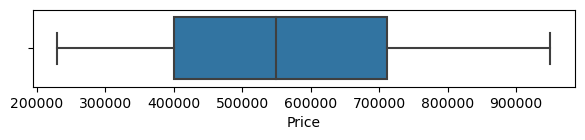

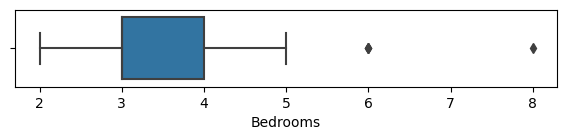

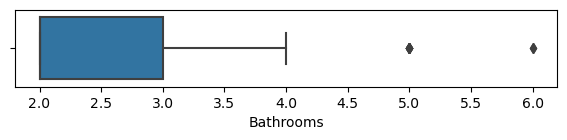

In [67]:
# creating boxplots to visualise data

import matplotlib.pyplot as plt

# selecting only non-object columns
numeric_columns = df_Dublin.select_dtypes(exclude='object').columns


for column in df_Dublin[numeric_columns]:
        plt.figure(figsize=(7,1))
        sns.boxplot(data=df_Dublin[numeric_columns], x=column)
       # plt.show()

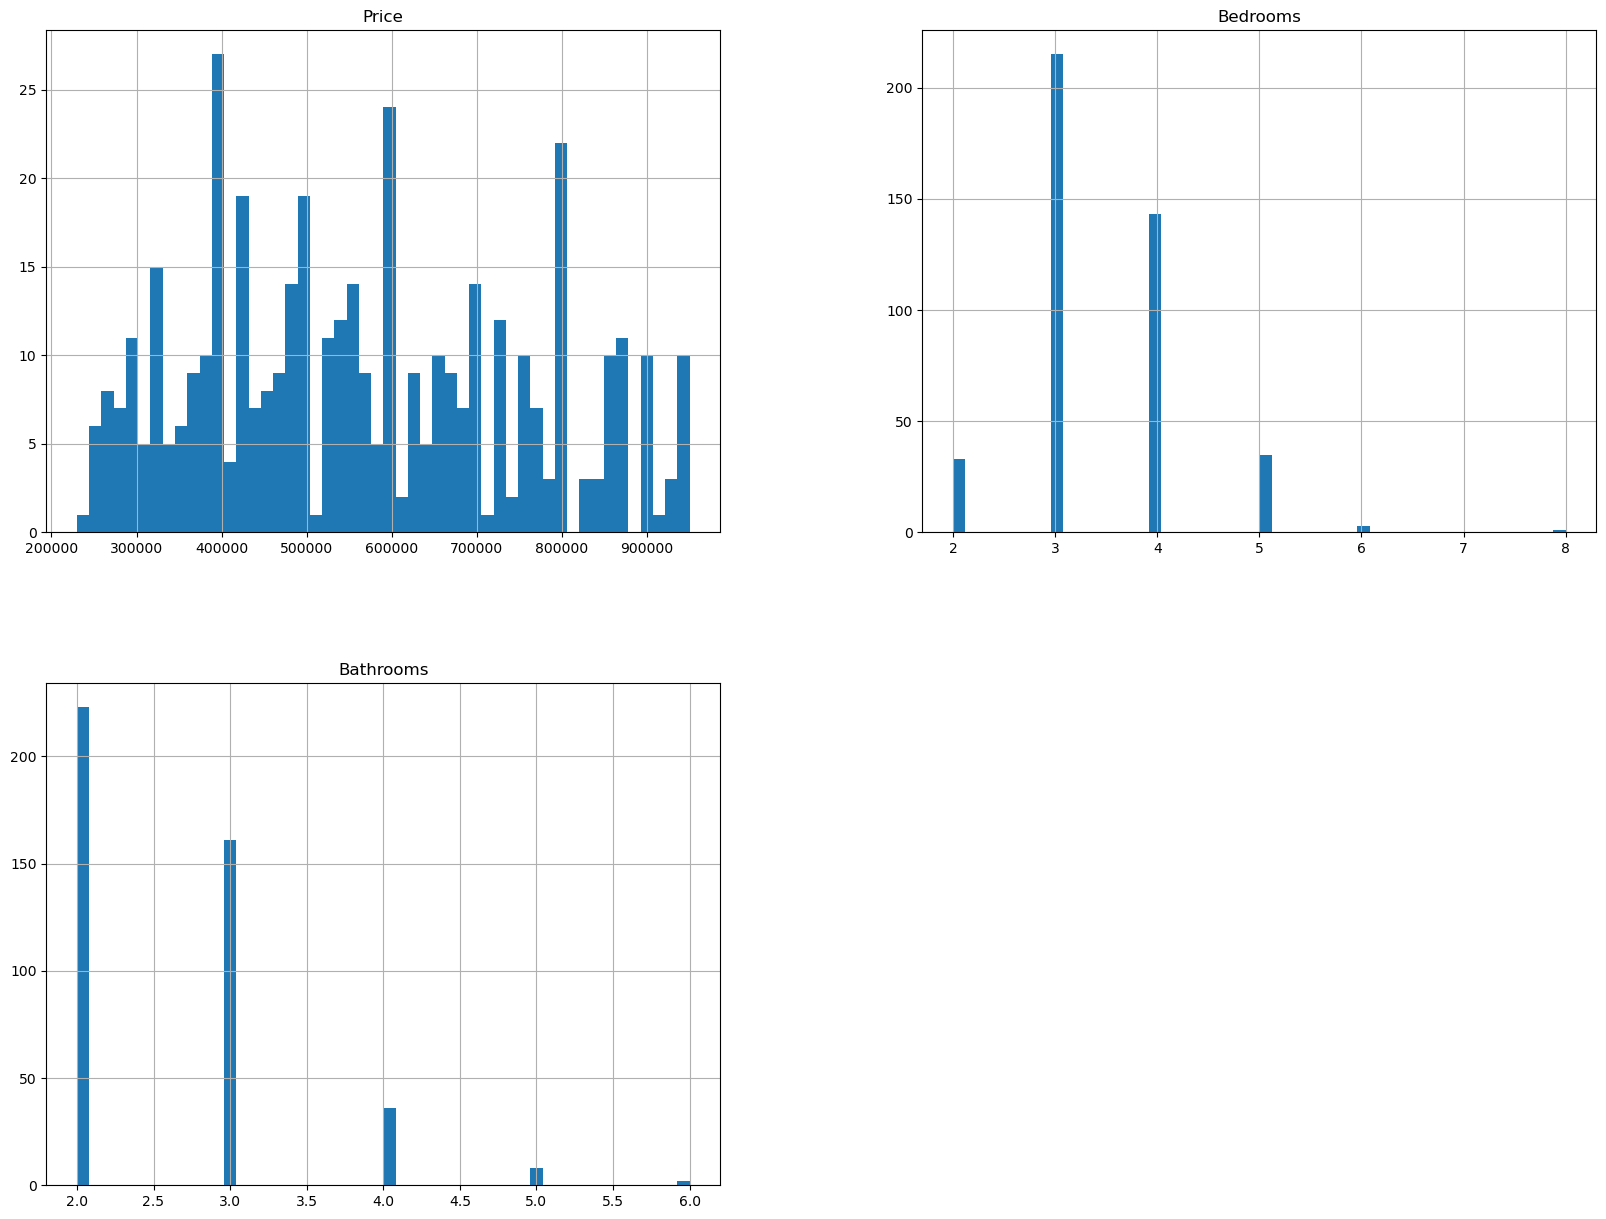

In [68]:
# creating a histograms
df_Dublin.hist(bins=50, figsize=(20,15))
plt.show()

## 2. Binary Classification

In [69]:
# getting dummies for 'House Type' column
df_Dublin = pd.get_dummies(df_Dublin, columns=['House Type'])
df_Dublin.head()

,Price,Bedrooms,Bathrooms,District,House Type_Detached House,House Type_Terrace House
0,550000,3,2,Dublin 15,0,1
2,775000,4,3,Co. Dublin,1,0
3,795000,4,5,Co. Dublin,1,0
4,449000,3,3,Co. Dublin,1,0
5,545000,4,2,Co. Dublin,1,0


In [70]:
# modifing 'District' column
df_Dublin['District'] = df_Dublin['District'].apply(lambda x: 'County' if 'Co.' in x else 'Dublin' if 'Dublin' in x else x)
df_Dublin.head()

,Price,Bedrooms,Bathrooms,District,House Type_Detached House,House Type_Terrace House
0,550000,3,2,Dublin,0,1
2,775000,4,3,County,1,0
3,795000,4,5,County,1,0
4,449000,3,3,County,1,0
5,545000,4,2,County,1,0


In [71]:
df_Dublin['Price'].describe()

count       430.000000
mean     564768.476744
std      189067.267221
min      230000.000000
25%      400000.000000
50%      549975.000000
75%      711000.000000
max      950000.000000
Name: Price, dtype: float64

In [72]:
start_value = 230000
end_value = 950000
num_groups = 5  # Number of groups to create

# Calculate the step size to evenly divide the range
step_size = (end_value - start_value) / num_groups

# Define the range labels for each group
range_labels = [f"{start_value + i * step_size}-{start_value + (i + 1) * step_size}" for i in range(num_groups)]

# Create the groups
groups = pd.cut(df_Dublin['Price'], bins=num_groups, labels=False)

# Create separate columns for each group using get_dummies and name the columns
group_columns = pd.get_dummies(groups, prefix='Price_Group')
group_columns.columns = ['Price_Group_' + range_labels[i] for i in range(num_groups)]

# Concatenate the group columns with the original DataFrame
df_Dublin = pd.concat([df_Dublin, group_columns], axis=1)

df_Dublin.head()

,Price,Bedrooms,Bathrooms,District,House Type_Detached House,House Type_Terrace House,Price_Group_230000.0-374000.0,Price_Group_374000.0-518000.0,Price_Group_518000.0-662000.0,Price_Group_662000.0-806000.0,Price_Group_806000.0-950000.0
0,550000,3,2,Dublin,0,1,0,0,1,0,0
2,775000,4,3,County,1,0,0,0,0,1,0
3,795000,4,5,County,1,0,0,0,0,1,0
4,449000,3,3,County,1,0,0,1,0,0,0
5,545000,4,2,County,1,0,0,0,1,0,0


In [73]:
df_Dublin.drop('Price', axis=1, inplace=True)

In [74]:
df_Dublin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 430 entries, 0 to 1099
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Bedrooms                       430 non-null    int32 
 1   Bathrooms                      430 non-null    int32 
 2   District                       430 non-null    object
 3   House Type_Detached House      430 non-null    uint8 
 4   House Type_Terrace House       430 non-null    uint8 
 5   Price_Group_230000.0-374000.0  430 non-null    uint8 
 6   Price_Group_374000.0-518000.0  430 non-null    uint8 
 7   Price_Group_518000.0-662000.0  430 non-null    uint8 
 8   Price_Group_662000.0-806000.0  430 non-null    uint8 
 9   Price_Group_806000.0-950000.0  430 non-null    uint8 
dtypes: int32(2), object(1), uint8(7)
memory usage: 13.0+ KB


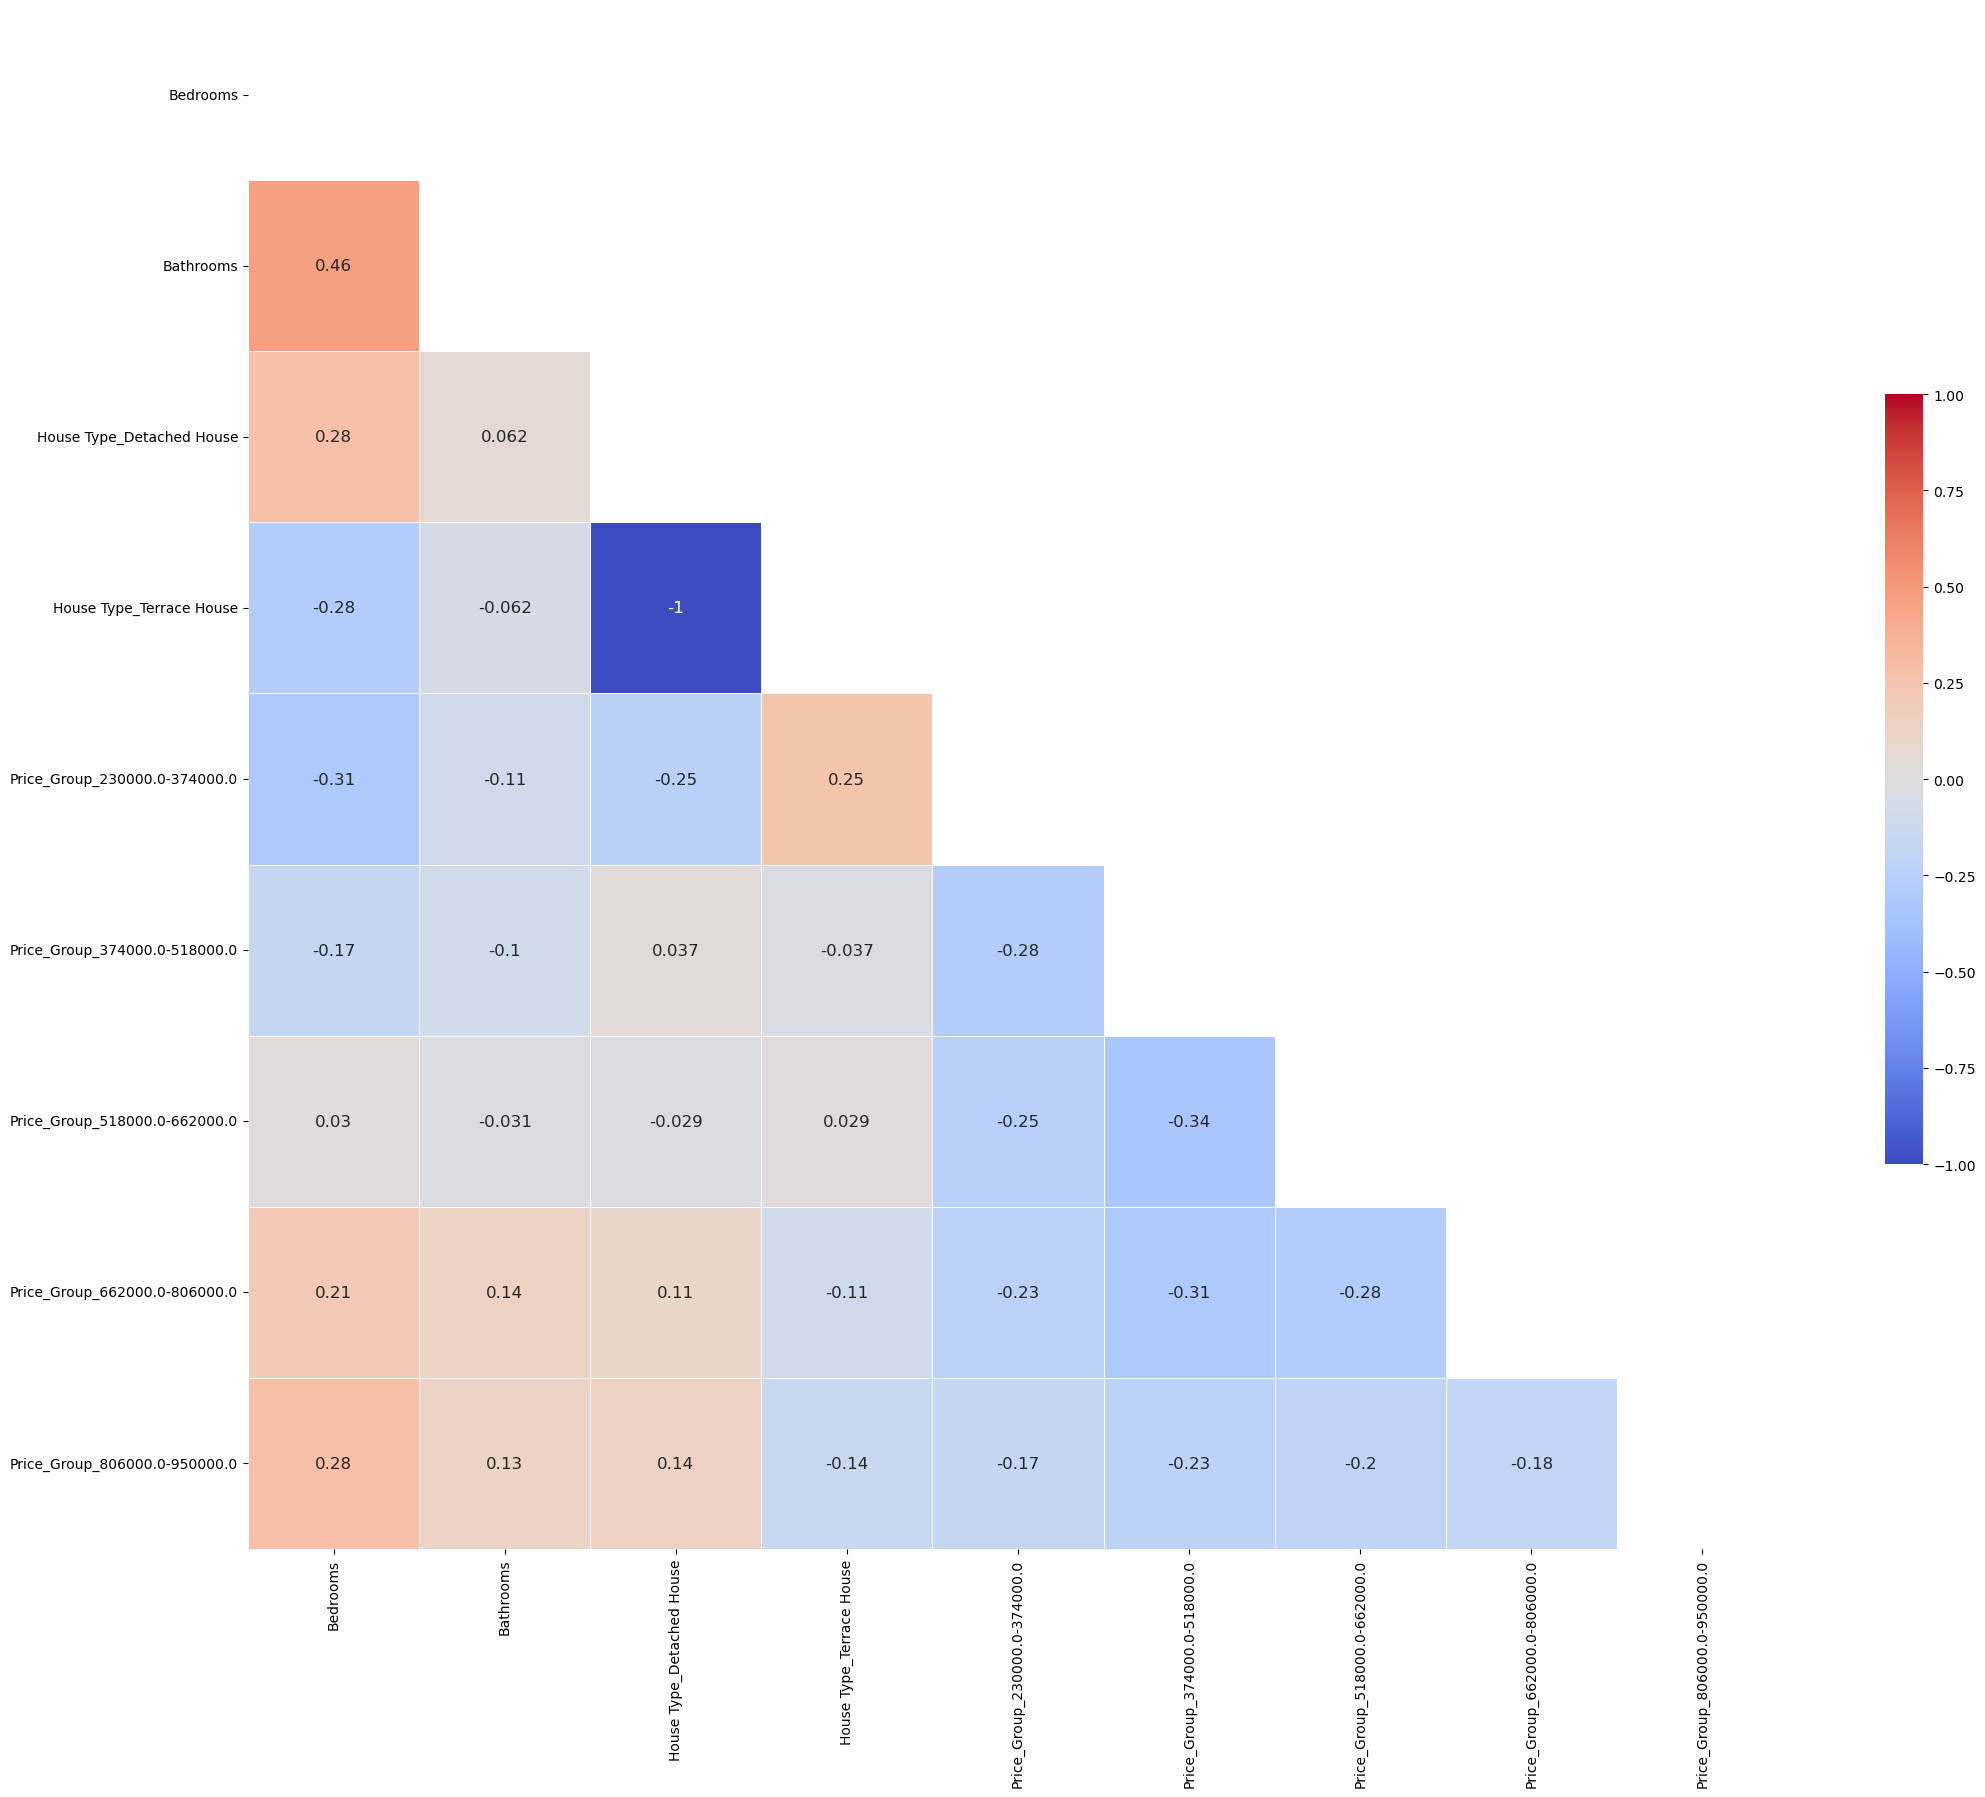

In [75]:
import numpy as np

# plotting heatmap
corrmat = df_Dublin.corr()

# setting mask for upper triangle
mask = np.triu(np.ones_like(corrmat, dtype=bool))

# setting hot-cold colour scheme
# cmap = sns.diverging_palette(240, 15, as_cmap=True)
cmap = 'coolwarm'

# plotting the graph
f, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(corrmat, square = True, mask=mask, cmap=cmap,
            vmax=1, vmin=-1, center=0,
            annot = True, annot_kws = {'size': 12},
            linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### a) Logistic Regression

In [76]:
# importing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [77]:
# separating features and target variable
X = df_Dublin.drop('District', axis=1)
y = df_Dublin['District']

In [78]:
# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
# creating a logistic regression model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# making predictions on the test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy_LR = accuracy_score(y_test, y_pred)
precision_LR = precision_score(y_test, y_pred, pos_label='Dublin')
recall_LR = recall_score(y_test, y_pred, pos_label='Dublin')
f1_LR = f1_score(y_test, y_pred, pos_label='Dublin')

# Calculate confusion matrix
confusion_mat_LR = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_LR}")
print(f"Precision: {precision_LR}")
print(f"Recall: {recall_LR}")
print(f"F1 Score: {f1_LR}")
print("Confusion Matrix:")
print(confusion_mat_LR)

Accuracy: 0.7325581395348837
Precision: 0.7317073170731707
Recall: 0.9836065573770492
F1 Score: 0.8391608391608392
Confusion Matrix:
[[ 3 22]
 [ 1 60]]


In [80]:
# checking size of each class
from collections import Counter

# summarize class distribution
print("Before oversampling: ",Counter(y_train))

Before oversampling:  Counter({'Dublin': 225, 'County': 119})


In [81]:
# oversampling using SMOTE
from imblearn.over_sampling import SMOTE

SMOTE = SMOTE()

# appling the transformation
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)

# summarize class distribution
print("After oversampling: ",Counter(y_train_SMOTE))

After oversampling:  Counter({'County': 225, 'Dublin': 225})


In [82]:
# Create a logistic regression model
model = LogisticRegression()

# Train the model
model.fit(X_train_SMOTE, y_train_SMOTE)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy_LR2 = accuracy_score(y_test, y_pred)
precision_LR2 = precision_score(y_test, y_pred, pos_label='Dublin')
recall_LR2 = recall_score(y_test, y_pred, pos_label='Dublin')
f1_LR2 = f1_score(y_test, y_pred, pos_label='Dublin')

# Calculate confusion matrix
confusion_mat_LR2 = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_LR2}")
print(f"Precision: {precision_LR2}")
print(f"Recall: {recall_LR2}")
print(f"F1 Score: {f1_LR2}")
print("Confusion Matrix:")
print(confusion_mat_LR2)

Accuracy: 0.5813953488372093
Precision: 0.7777777777777778
Recall: 0.5737704918032787
F1 Score: 0.660377358490566
Confusion Matrix:
[[15 10]
 [26 35]]


In [83]:
# Tunning hyperparameters

# Define the parameter grid for grid search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_SMOTE, y_train_SMOTE)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(best_params)

# Train the model with the best hyperparameters
best_model = LogisticRegression(**best_params)
best_model.fit(X_train_SMOTE, y_train_SMOTE)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
accuracy_LR3 = accuracy_score(y_test, y_pred)
precision_LR3 = precision_score(y_test, y_pred, pos_label='Dublin')
recall_LR3 = recall_score(y_test, y_pred, pos_label='Dublin')
f1_LR3 = f1_score(y_test, y_pred, pos_label='Dublin')

# Calculate confusion matrix
confusion_mat_LR3 = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics and confusion matrix
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy_LR3}")
print(f"Precision: {precision_LR3}")
print(f"Recall: {recall_LR3}")
print(f"F1 Score: {f1_LR3}")
print("Confusion Matrix:")
print(confusion_mat_LR3)

Best Hyperparameters:
{'C': 0.001}
Evaluation Metrics:
Accuracy: 0.5813953488372093
Precision: 0.7906976744186046
Recall: 0.5573770491803278
F1 Score: 0.6538461538461539
Confusion Matrix:
[[16  9]
 [27 34]]


# SVC

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [ ]:
# Create an SVM classifier with default parameters
svm_classifier = SVC()

# Train the SVM model
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy_SVC = accuracy_score(y_test, y_pred)
precision_SVC = precision_score(y_test, y_pred, pos_label='Dublin')
recall_SVC = recall_score(y_test, y_pred, pos_label='Dublin')
f1_SVC = f1_score(y_test, y_pred, pos_label='Dublin')

# Print the evaluation metrics
print(f"Accuracy: {accuracy_SVC}")
print(f"Precision: {precision_SVC}")
print(f"Recall: {recall_SVC}")
print(f"F1 Score: {f1_SVC}")

# Calculate confusion matrix
confusion_mat_SVC = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat_SVC)

In [ ]:
# training the SVM model
svm_classifier.fit(X_train_SMOTE, y_train_SMOTE)

# making the predictions on the test set
y_pred = svm_classifier.predict(X_test)

# calculating evaluation metrics
accuracy_SVC2 = accuracy_score(y_test, y_pred)
precision_SVC2 = precision_score(y_test, y_pred, pos_label='Dublin')
recall_SVC2 = recall_score(y_test, y_pred, pos_label='Dublin')
f1_SVC2 = f1_score(y_test, y_pred, pos_label='Dublin')

# printing the evaluation metrics
print(f"Accuracy: {accuracy_SVC2}")
print(f"Precision: {precision_SVC2}")
print(f"Recall: {recall_SVC2}")
print(f"F1 Score: {f1_SVC2}")

# calculating confusion matrix
confusion_mat_SVC2 = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(confusion_mat_SVC2)

In [ ]:

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Create an SVC classifier
svm_classifier = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5)
grid_search.fit(X_train_SMOTE, y_train_SMOTE)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best hyperparameters to create the final SVC model
best_svm_classifier = SVC(**best_params)
best_svm_classifier.fit(X_train_SMOTE, y_train_SMOTE)

# Make predictions on the test set
y_pred = best_svm_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy_SVC3 = accuracy_score(y_test, y_pred)
precision_SVC3 = precision_score(y_test, y_pred, pos_label='Dublin')
recall_SVC3 = recall_score(y_test, y_pred, pos_label='Dublin')
f1_SVC3 = f1_score(y_test, y_pred, pos_label='Dublin')

# Print the evaluation metrics
print(f"Accuracy: {accuracy_SVC3}")
print(f"Precision: {precision_SVC3}")
print(f"Recall: {recall_SVC3}")
print(f"F1 Score: {f1_SVC3}")

# calculating confusion matrix
confusion_mat_SVC3 = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(confusion_mat_SVC3)